In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [7]:
# Load dataset
file_path = "../../data/ethusd_group_project.csv"
df = pd.read_csv(file_path, parse_dates=['time'])

#remove NaN values
df = df.dropna()

# Ensure time is sorted
df = df.sort_values(by="time")

# Set time as index
df.set_index('time', inplace=True)

In [71]:
# Create Input Sequences
def create_sequences(data, target, lookback=60):
    X, y = [], []
    temp = data[target].values
    for i in range(len(data) - lookback):
        X.append(temp[i:i+lookback])  # Use daily return of past days as input
        y.append(temp[i+lookback]**2)    # Use square return as a proxy of variance
    return np.array(X), np.array(y)

# daily_return would be the input for GARCH models
target = 'daily_return'

# Use 30-day rolling window
lookback = 30 
# Create sequences
X, y = create_sequences(df, target, lookback)

### Train-Test Split

In [83]:
# Train-Test Split (80% train, 10% validation, 10% test)

train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Further split training into training & validation (80% train, 20% validation)
# val_size = int(len(X_train) * 0.2)  # 20% of training data
# X_val, y_val = X_train[-val_size:], y_train[-val_size:]  # Last 20% for validation
# X_train, y_train = X_train[:-val_size], y_train[:-val_size]  # Remaining for training

print("Training Set:", X_train.shape, y_train.shape)
# print("Validation Set:", X_val.shape, y_val.shape)
print("Test Set:", X_test.shape, y_test.shape)

Training Set: (2088, 30) (2088,)
Test Set: (523, 30) (523,)


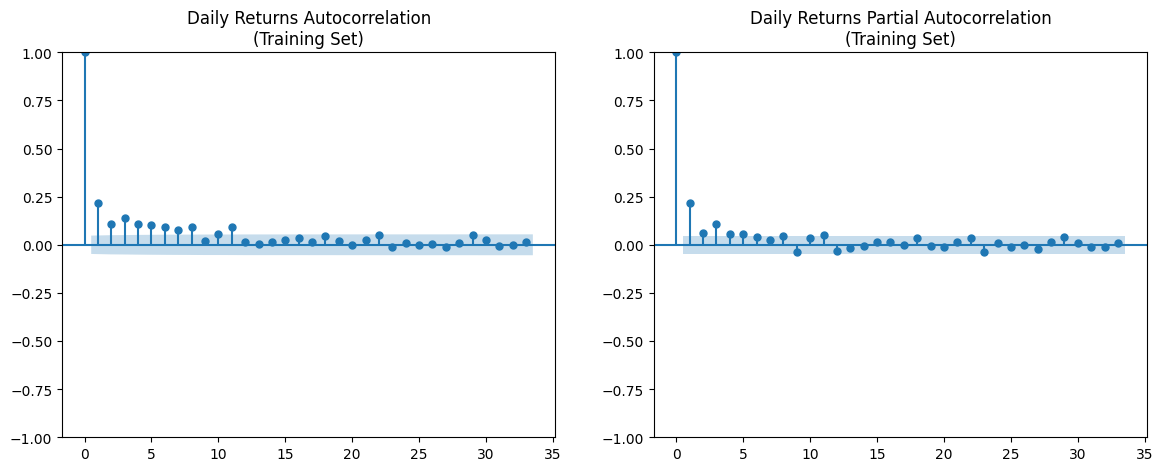

In [73]:
# Visualize the ACF and PACF of the returns
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(y_train, title='Daily Returns Autocorrelation\n(Training Set)', ax=ax[0])
plot_pacf(y_train, title='Daily Returns Partial Autocorrelation\n(Training Set)', ax=ax[1])
plt.show()

### Optimise p and q

In [74]:
# Store results
results = []

# Define range of p and q values to test
p_range = range(1, 5)
q_range = range(1, 5)

# Loop over all (p, q) combinations
for p in p_range:
    for q in q_range:
        predicted_volatility = []

        try:
            # Fit GARCH model for each window           
            for j in range(len(X_train)):
            # for j in range(10):
                window = X_train[j]
                model = arch_model(window, vol='Garch', p=p, q=q, rescale=False)
                garch_fit = model.fit(disp="off")
                pred = garch_fit.forecast(horizon=1).variance.iloc[-1].values[0]
                predicted_volatility.append(pred)
                
            # Compute MSE
            # mse = mean_squared_error(y_train[:10], predicted_volatility)
            mse = mean_squared_error(y_train, predicted_volatility)
            rmse = np.sqrt(mse)
            results.append((p, q, rmse))

        except Exception as e:
            print(f"Skipping GARCH({p},{q}) due to error: {e}")

In [75]:
# Convert results to a DataFrame
gm_results = pd.DataFrame(results, columns=['p', 'q', 'RMSE'])

In [76]:
gm_results

,p,q,RMSE
0,1,1,0.006641
1,1,2,0.006634
2,1,3,0.006676
3,1,4,0.006797
4,2,1,0.006632
5,2,2,0.006634
6,2,3,0.006854
7,2,4,0.006796
8,3,1,0.006682
9,3,2,0.006656


In [77]:
# Find the best (p, q) with the lowest RMSE
best_params = gm_results.loc[gm_results['RMSE'].idxmin()]
best_p = best_params['p']
best_q = best_params['q']
best_rmse = best_params['RMSE']
print(f"Best GARCH({best_p},{best_q}) model with RMSE={best_rmse:.6f}")

Best GARCH(2.0,1.0) model with RMSE=0.006632


### Best GARCH Model

In [70]:
p = 2
q = 1

In [78]:
# Initialize list for storing predicted volatility (standard deviation)
predicted_volatility = []

# Compute forcase volatility on the test set
for j in range(len(X_test)):
# for j in range(10):
    window = X_test[j]
    model = arch_model(window, vol='Garch', p=p, q=q, rescale=False)
    garch_fit = model.fit(disp="off")
    pred = garch_fit.forecast(horizon=1).variance.iloc[-1].values[0]
    predicted_volatility.append(pred)

In [80]:
# Calculate Error Metrics
# mse = mean_squared_error(y_test, predicted_volatility)
# rmse = np.sqrt(mse)
# mape = mean_absolute_percentage_error(y_test, predicted_volatility)
# r2 = r2_score(y_test, predicted_volatility)
mse = mean_squared_error(y_test[:10], predicted_volatility)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test[:10], predicted_volatility)
r2 = r2_score(y_test[:10], predicted_volatility)

# Print evaluation metrics
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.6%}")
print(f"R² Score: {r2:.6f}")

Mean Squared Error (MSE): 0.000014
Root Mean Squared Error (RMSE): 0.003797
Mean Absolute Percentage Error (MAPE): 495.802869%
R² Score: -0.450078


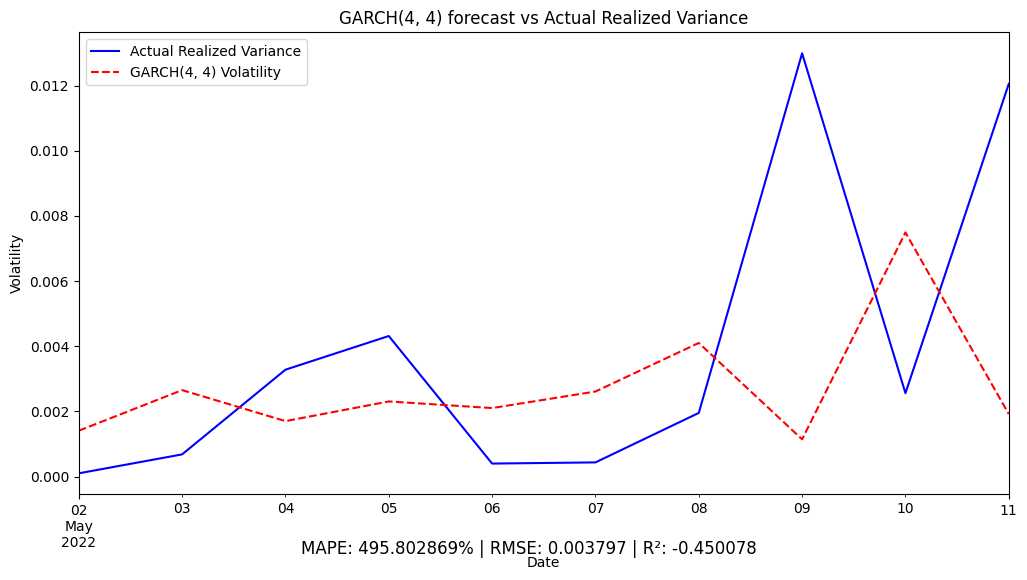

In [91]:
# Create a DataFrame for visualization
df_pred = pd.DataFrame({'Predicted Volatility': predicted_volatility}, 
                       index=df['daily_return'][-len(y_test):-len(y_test)+10].index)
df_actual = pd.DataFrame({'Actual Volatility': y_test[:10]}, 
                         index=df['daily_return'][-len(y_test):-len(y_test)+10].index)

# Plot the predicted volatility against the realized volatility on the test set
plt.figure(figsize=(12, 6))
df_actual['Actual Volatility'].plot(label='Actual Realized Variance', color="blue")
df_pred['Predicted Volatility'].plot(label=f'GARCH({p}, {q}) Volatility', color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title(f"GARCH({p}, {q}) forecast vs Actual Realized Variance")
plt.legend()
#add captions
plt.figtext(0.5, 0.01, f"MAPE: {mape:.6%} | RMSE: {rmse:.6f} | R²: {r2:.6f}", wrap=True, 
            horizontalalignment='center', fontsize=12)
plt.savefig(f'../../results/figures/GARCH({p}, {q})_plot.png')
plt.show()

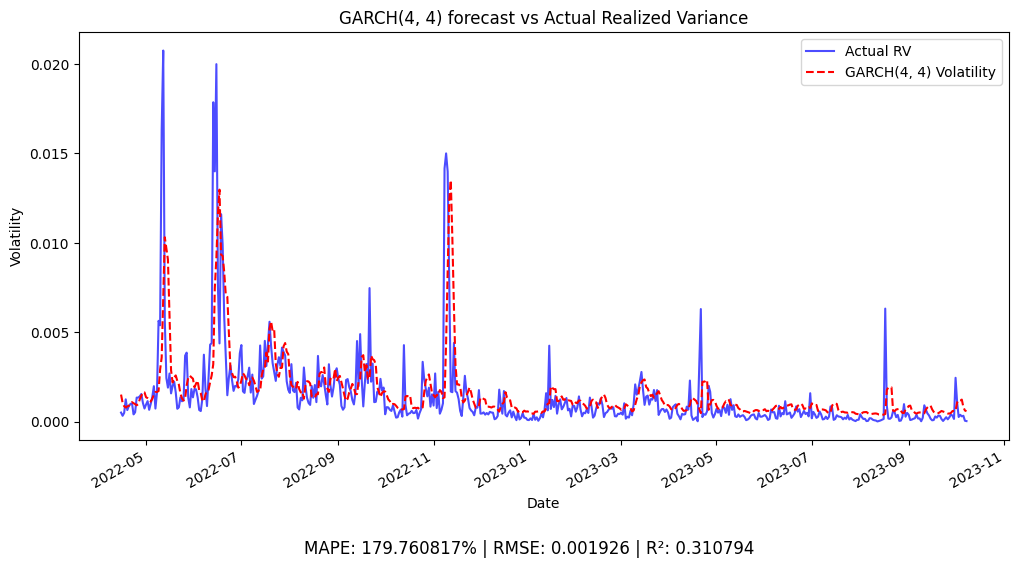

In [527]:
# Create a DataFrame for visualization
df_pred = pd.DataFrame({'Predicted Volatility': predicted_volatility}, 
                       index=df['daily_return'][-len(y_test):].index)
df_actual = pd.DataFrame({'Actual Volatility': y_test}, index=df['daily_return'][-len(y_test):].index)

# Plot the predicted volatility against the realized volatility on the test set
plt.figure(figsize=(12, 6))
df_actual['Actual Volatility'].plot(label='Actual Realized Variance', color="blue")
df_pred['Predicted Volatility'].plot(label=f'GARCH({p}, {q}) Volatility', color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title(f"GARCH({p}, {q}) forecast vs Actual Realized Variance")
plt.legend()
#add captions
plt.figtext(0.5, 0.01, f"MAPE: {mape:.6%} | RMSE: {rmse:.6f} | R²: {r2:.6f}", wrap=True, 
            horizontalalignment='center', fontsize=12)
plt.savefig(f'../../results/figures/GARCH({p}, {q})_plot.png')
plt.show()